In [1]:
import pandas as pd
import numpy as np
import yaml
import os
import sys
# Get the current working directory
working_dir = '/arc/project/st-ashapi01-1/git/afraz96/RADD/workflows/part2_version2'
sys.path.append(working_dir)
import train
import test
# Append the src directory to the Python path
src_dir = os.path.join(working_dir, 'src')
sys.path.append(src_dir)

# Path to the config file
config_path = os.path.join(working_dir, 'config', 'config.yaml')
import utils

with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
import logging
import pickle
from sklearn import preprocessing
import math
import time
# Import the ML Models
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost
from tensorflow.keras.models import Sequential, model_from_json
import tensorflow as tf

2024-10-02 09:17:46.253867: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-02 09:17:47.678564: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-02 09:17:47.682042: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 09:17:53.154339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load in the models and check the compounds they predict on

In [2]:
high_res_data = pd.read_csv(os.path.join(working_dir, 'Data/NEW_HIGH_RES_2023_SMILES.csv'))
x500r_data = pd.read_csv(os.path.join(working_dir, 'Data/NEW_X500R_SMILES.csv'))
bccdc_data = pd.read_csv(os.path.join(working_dir, 'Data/training_data_bccdc_20240708.csv'))

# Load the ML models trained and the preprocessors

In [3]:
ml_models_dir = '/scratch/st-ashapi01-1/RADD/SMILES_ML_PIPELINE'
bccdc_output_dir = 'NPS_OUTPUT'
x500r_output_dir = 'X500R_OUTPUT'

In [4]:
def read_ml_models(directory):
    all_models = []
    for root, dirs, files in os.walk(os.path.join(directory, 'models')):
        for file in files:
            if file.endswith('.json'):
                    json_file = open(root + '/' + file, 'r')
                    loaded_model_json = json_file.read()
                    loaded_model = model_from_json(loaded_model_json)
                    all_models.append(loaded_model)
                    json_file.close() 
            elif file.endswith('.pkl'):
                with open(root + '/' + file, 'rb') as f:
                    all_models.append(pickle.load(f))
            elif file.endswith('.h5'):
                neural_net_weights = os.path.join(root, file)

        for i in all_models:
            if isinstance(i, tf.keras.Model):
                i.load_weights(neural_net_weights)

        with open(os.path.join(directory, 'processor.pkl'), 'rb') as f:
            processor = pickle.load(f)
    return all_models, processor
        

In [5]:
bccdc_models, bccdc_processor = read_ml_models(os.path.join(ml_models_dir, bccdc_output_dir))
x500r_models, x500r_processor = read_ml_models(os.path.join(ml_models_dir, x500r_output_dir))

In [6]:
## Load configurations
model_X = 'SMILES'
bccdc_model_index = 'Name'
x500r_model_index = 'Compound'
bccdc_model_y = 'PTC Confirmed RT'
x500r_model_y = 'Retention Time (min)'

In [7]:
def create_model_predictions(df, model_df, all_models, processor, database_name=''):
    # Instaniate the Encoder
    vectorizer = train.SMILESVectorizer()
    vectorizer.fit(model_df[model_X].to_list())
    df_vectorized, _ = vectorizer.transform(df[model_X].to_list())

    # Flatten and create feature names
    df_flattened = train.flatten_and_create_feature_names(df_vectorized)

    # Combine with additional features (assuming no additional features in this example)
    combined_df = train.combine_with_additional_features(df_flattened, None)

    # you have the normalized data now
    norm_X = processor.transform(combined_df)

    # Make the predictions
    model_names = config['model_names']
    df_col_names = []
    for i,name in enumerate(model_names):
        df_col_names.append(database_name + name + '_prediction')
        df[database_name + name + '_prediction'] = all_models[i].predict(norm_X)
    return df, df_col_names

In [8]:
# drop na
bccdc_data.dropna(subset=['SMILES'], inplace=True)

In [9]:
bccdc_data, bccdc_model_names = create_model_predictions(bccdc_data, bccdc_data, bccdc_models, bccdc_processor)
x500r_data, x500r_model_names = create_model_predictions(x500r_data, x500r_data, x500r_models, x500r_processor)

max_smiles_length: [24, 30, 42, 35, 35, 50, 40, 40, 37, 40, 37, 21, 48, 30, 47, 36, 14, 30, 25, 34, 37, 35, 32, 30, 30, 62, 30, 44, 28, 47, 30, 37, 30, 32, 39, 38, 33, 44, 37, 37, 36, 39, 31, 36, 41, 26, 36, 36, 43, 32, 34, 29, 35, 33, 47, 27, 45, 30, 30, 28, 38, 38, 45, 38, 38, 46, 46, 44, 33, 19, 53, 56, 18, 39, 36, 31, 39, 29, 55, 61, 29, 23, 20, 26, 58, 35, 37, 31, 22, 29, 25, 39, 17, 38, 15, 29, 26, 26, 32, 27, 19, 38, 28, 50, 36, 42, 44, 16, 42, 56, 32, 26, 33, 23, 26, 37, 27, 28, 31, 35, 28, 33, 42, 39, 36, 34, 40, 28, 26, 18, 17, 33, 18, 26, 38, 30, 34, 40, 27, 18, 38, 37, 49, 34, 62, 41, 38, 37, 42, 29, 42, 39, 44, 32, 31, 32, 38, 63, 32, 52, 39, 22, 40, 46, 39, 46, 39]
Charset Size: 39
Char to Int Mapping: {'l': 1, 'y': 2, '@': 3, '3': 4, 'H': 5, 'S': 6, 'F': 7, 'C': 8, 'r': 9, 's': 10, '/': 11, 'c': 12, 'o': 13, '+': 14, 'I': 15, '5': 16, '(': 17, '2': 18, ')': 19, '9': 20, 'i': 21, '#': 22, '6': 23, '8': 24, '4': 25, '=': 26, '1': 27, 'O': 28, '[': 29, 'D': 30, 'B': 31, ']'

In [10]:
high_res_data, bccdc_model_names = create_model_predictions(high_res_data, bccdc_data, bccdc_models, bccdc_processor, 'bccdc_')
high_res_data, x500r_model_names = create_model_predictions(high_res_data, x500r_data, x500r_models, x500r_processor, 'X500R_')

max_smiles_length: [24, 30, 42, 35, 35, 50, 40, 40, 37, 40, 37, 21, 48, 30, 47, 36, 14, 30, 25, 34, 37, 35, 32, 30, 30, 62, 30, 44, 28, 47, 30, 37, 30, 32, 39, 38, 33, 44, 37, 37, 36, 39, 31, 36, 41, 26, 36, 36, 43, 32, 34, 29, 35, 33, 47, 27, 45, 30, 30, 28, 38, 38, 45, 38, 38, 46, 46, 44, 33, 19, 53, 56, 18, 39, 36, 31, 39, 29, 55, 61, 29, 23, 20, 26, 58, 35, 37, 31, 22, 29, 25, 39, 17, 38, 15, 29, 26, 26, 32, 27, 19, 38, 28, 50, 36, 42, 44, 16, 42, 56, 32, 26, 33, 23, 26, 37, 27, 28, 31, 35, 28, 33, 42, 39, 36, 34, 40, 28, 26, 18, 17, 33, 18, 26, 38, 30, 34, 40, 27, 18, 38, 37, 49, 34, 62, 41, 38, 37, 42, 29, 42, 39, 44, 32, 31, 32, 38, 63, 32, 52, 39, 22, 40, 46, 39, 46, 39]
Charset Size: 39
Char to Int Mapping: {'l': 1, 'y': 2, '@': 3, '3': 4, 'H': 5, 'S': 6, 'F': 7, 'C': 8, 'r': 9, 's': 10, '/': 11, 'c': 12, 'o': 13, '+': 14, 'I': 15, '5': 16, '(': 17, '2': 18, ')': 19, '9': 20, 'i': 21, '#': 22, '6': 23, '8': 24, '4': 25, '=': 26, '1': 27, 'O': 28, '[': 29, 'D': 30, 'B': 31, ']'

In [11]:
high_res_data.head()

,Compound,PMF,Pmass,F1mass,F2mass,F3mass,F4mass,F5mass,F6mass,F1_n,...,bccdc_LGBM_prediction,bccdc_Neural Network_prediction,bccdc_Random Forest_prediction,bccdc_XGBoost_prediction,X500R_CatBoost_prediction,X500R_Lasso_prediction,X500R_LGBM_prediction,X500R_Neural Network_prediction,X500R_Random Forest_prediction,X500R_XGBoost_prediction
0,(Iso)butyryl-F-fentanyl N-benzyl analogue,C22H27FN2O,355.2180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.367223,3.764655,4.649347,4.350983,7.813790,8.208798,7.531093,7.656129,7.023856,7.628216
1,"1-(1,3-Diphenylpropan-2-yl)pyrrolidine",C19H23N,266.1903,91.0542,117.0699,72.0808,NaN,NaN,NaN,1.0,...,3.821193,4.670467,4.724676,4.833315,6.150524,6.972257,5.298522,6.335971,6.293439,5.867353
2,1-(1-Phenylcyclohexyl)azepane,C18H27N,258.2216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.740458,4.293675,4.271422,4.294889,6.166313,7.609275,4.789313,6.326034,6.108912,6.118053
3,1-(1-Phenylcyclohexyl)azetidine,C15H21N,216.1747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.229661,4.516868,4.722217,4.437869,5.087007,5.803316,3.028951,4.542433,3.818315,5.051534
4,"1-(2,3,4-Trimethoxybenzyl)piperazine",C14H22N2O3,267.1703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.559530,4.412185,4.537919,4.304276,5.258948,4.308864,4.546580,4.603775,5.015550,5.189165


In [12]:
from datetime import datetime

current_date = datetime.now().strftime('%Y-%m-%d')

In [13]:
merged_df = pd.merge(high_res_data, bccdc_data[['SMILES', 'PTC Confirmed RT']], on='SMILES', how='left')
merged_df = pd.merge(merged_df, x500r_data[['SMILES', 'Retention Time (min)']], on='SMILES', how='left')

In [14]:
merged_df.head()

,Compound,PMF,Pmass,F1mass,F2mass,F3mass,F4mass,F5mass,F6mass,F1_n,...,bccdc_Random Forest_prediction,bccdc_XGBoost_prediction,X500R_CatBoost_prediction,X500R_Lasso_prediction,X500R_LGBM_prediction,X500R_Neural Network_prediction,X500R_Random Forest_prediction,X500R_XGBoost_prediction,PTC Confirmed RT,Retention Time (min)
0,(Iso)butyryl-F-fentanyl N-benzyl analogue,C22H27FN2O,355.2180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.649347,4.350983,7.813790,8.208798,7.531093,7.656129,7.023856,7.628216,NaN,NaN
1,"1-(1,3-Diphenylpropan-2-yl)pyrrolidine",C19H23N,266.1903,91.0542,117.0699,72.0808,NaN,NaN,NaN,1.0,...,4.724676,4.833315,6.150524,6.972257,5.298522,6.335971,6.293439,5.867353,NaN,NaN
2,1-(1-Phenylcyclohexyl)azepane,C18H27N,258.2216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.271422,4.294889,6.166313,7.609275,4.789313,6.326034,6.108912,6.118053,NaN,NaN
3,1-(1-Phenylcyclohexyl)azetidine,C15H21N,216.1747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.722217,4.437869,5.087007,5.803316,3.028951,4.542433,3.818315,5.051534,NaN,NaN
4,"1-(2,3,4-Trimethoxybenzyl)piperazine",C14H22N2O3,267.1703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.537919,4.304276,5.258948,4.308864,4.546580,4.603775,5.015550,5.189165,NaN,NaN


In [15]:
merged_df['PTC Confirmed RT'].isnull().sum()

2240

In [16]:
merged_df.to_csv('/scratch/st-ashapi01-1/RADD/SMILES_ML_PIPELINE/high_res_prediction_both_models_' + current_date + '.csv', index=False)


In [17]:
bccdc_data.shape

(167, 32)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
def make_error_bins(df, model_names, model_y):
    # Calculate errors
    for model in model_names:
        df[f'{model}_error'] = abs(df[model] - df[model_y])

    # Convert to long format manually
    long_data = []
    for index, row in df.iterrows():
        for model in model_names:
            if model != 'model_y':
                long_data.append({
                    'Compound' : row[model_X],
                    'Actual RT': row[model_y],
                    'model': model,
                    'prediction': row[model],
                    'error': row[f'{model}_error'],
                    'under_over': 'Under' if row[model] < row[model_y] else 'Over'
                })

    df_long = pd.DataFrame(long_data)

    # Function to bin errors
    def bin_errors(error):
        if error <= 1.0:
            return '<= 1.0'
        elif 1.0 < error <= 2.0:
            return '> 1.0 and <= 2.0'
        else:
            return '> 2.0'

    # Apply binning
    df_long['error_bin'] = df_long['error'].apply(bin_errors)
    return df_long

In [20]:
def error_bin_plots(df_long, output_dir, filename='error_plots.png'):
    # Plotting with seaborn
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_long, x='model', hue='error_bin')
    plt.title('Error Distribution Across Models')
    plt.xlabel('Model')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Error Bin')
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(output_dir, filename))

In [21]:
bccdc_only_high_res = merged_df[merged_df['PTC Confirmed RT'].notnull()]

In [22]:
bccdc_only_high_res.shape

(94, 34)

/tmp/ipykernel_2394430/2691008910.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{model}_error'] = abs(df[model] - df[model_y])
/tmp/ipykernel_2394430/2691008910.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{model}_error'] = abs(df[model] - df[model_y])
/tmp/ipykernel_2394430/2691008910.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

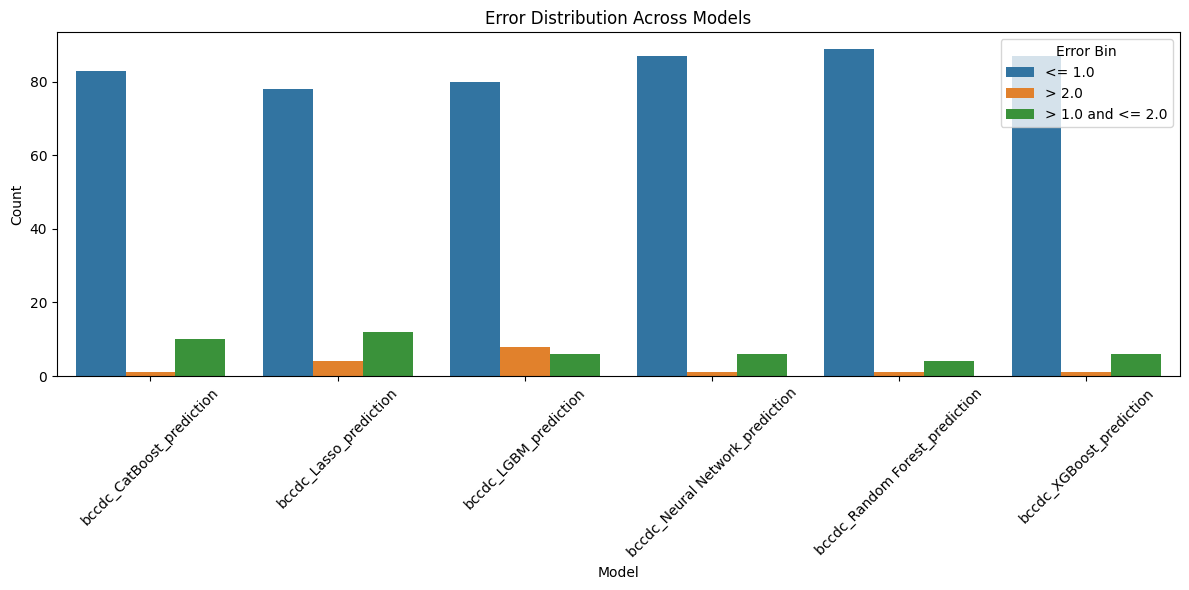

FileNotFoundError: [Errno 2] No such file or directory: '/arc/project/st-ashapi01-1/git/afraz96/RADD/workflows/part2_version2/Notebooks/Figures/error_bccdc_on_high_res.png'

<Figure size 640x480 with 0 Axes>

In [23]:
high_res_plot_df = make_error_bins(bccdc_only_high_res, bccdc_model_names, bccdc_model_y)
error_bin_plots(high_res_plot_df, 'Figures', 'error_bccdc_on_high_res.png')

In [24]:
high_res_plot_df

,Compound,Actual RT,model,prediction,error,under_over,error_bin
0,Nc1ccc2c(c1)C(c1ccccc1Cl)=NCC(=O)N2,4.28,bccdc_CatBoost_prediction,4.631853,0.351853,Over,<= 1.0
1,Nc1ccc2c(c1)C(c1ccccc1Cl)=NCC(=O)N2,4.28,bccdc_Lasso_prediction,4.539026,0.259026,Over,<= 1.0
2,Nc1ccc2c(c1)C(c1ccccc1Cl)=NCC(=O)N2,4.28,bccdc_LGBM_prediction,4.279419,0.000581,Under,<= 1.0
3,Nc1ccc2c(c1)C(c1ccccc1Cl)=NCC(=O)N2,4.28,bccdc_Neural Network_prediction,4.421601,0.141601,Over,<= 1.0
4,Nc1ccc2c(c1)C(c1ccccc1Cl)=NCC(=O)N2,4.28,bccdc_Random Forest_prediction,4.277031,0.002969,Under,<= 1.0
...,...,...,...,...,...,...,...
559,CN1CCN(C(=O)OC2c3nccnc3C(=O)N2c2ccc(Cl)cn2)CC1,4.08,bccdc_Lasso_prediction,4.311009,0.231009,Over,<= 1.0
560,CN1CCN(C(=O)OC2c3nccnc3C(=O)N2c2ccc(Cl)cn2)CC1,4.08,bccdc_LGBM_prediction,4.075814,0.004186,Under,<= 1.0
561,CN1CCN(C(=O)OC2c3nccnc3C(=O)N2c2ccc(Cl)cn2)CC1,4.08,bccdc_Neural Network_prediction,4.072472,0.007528,Under,<= 1.0
562,CN1CCN(C(=O)OC2c3nccnc3C(=O)N2c2ccc(Cl)cn2)CC1,4.08,bccdc_Random Forest_prediction,4.075287,0.004713,Under,<= 1.0


In [26]:
high_res_plot_df.to_csv('temp_results.csv', index=False)